# Heart Failure - Modeling

## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

from library.sb_utils import save_file

In [2]:
patient_data = pd.read_csv('../data/patient_data_cleaned.csv')
patient_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,False,Normal,172,N,0.0,Up,False
1,49,F,NAP,160,180.0,False,Normal,156,N,1.0,Flat,True
2,37,M,ATA,130,283.0,False,ST,98,N,0.0,Up,False
3,48,F,ASY,138,214.0,False,Normal,108,Y,1.5,Flat,True
4,54,M,NAP,150,195.0,False,Normal,122,N,0.0,Up,False


In [3]:
X_train = pd.read_csv('../data/patient_data_X_train.csv')
X_train.shape

(687, 15)

In [4]:
X_test = pd.read_csv('../data/patient_data_X_test.csv')
X_test.shape

(230, 15)

In [5]:
y_train = pd.read_csv('../data/patient_data_y_train.csv')
y_train = y_train.values.reshape(-1)
y_train.shape

(687,)

In [6]:
y_test = pd.read_csv('../data/patient_data_y_test.csv')
y_test = y_test.values.reshape(-1)
y_test.shape

(230,)

## Initial Baseline-Model<a id='Initial_Baseline-Model'></a>

In [7]:
#Baseline-Model based on uniform random predictions
dumb_clf = DummyClassifier(strategy='uniform', random_state=42)
dumb_clf.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='uniform')

In [8]:
y_tr_pred = dumb_clf.predict(X_train)
y_tr_pred[:5]

array([0, 1, 0, 0, 0])

In [9]:
y_te_pred = dumb_clf.predict(X_test)
y_te_pred[:5]

array([0, 1, 0, 0, 0])

### Scoring Model

In [10]:
def ROC_AUC_Graph(model):
    #Generate a baseline prediction
    bs_probs = [0 for i in range(len(y_test))]
    op_probs = model.predict(X_test)

    #Calculate scores
    bs_auc = roc_auc_score(y_test, bs_probs)
    op_auc = roc_auc_score(y_test, op_probs)


    print('Baseline Algorithm:ROC AUC=%.3f' % (bs_auc))
    print('Baseline Model: ROC AUC=%.3f' % (op_auc))

    #Calculate roc curves
    bs_fpr, bs_tpr, _ = roc_curve(y_test, bs_probs)
    op_fpr, op_tpr, _ = roc_curve(y_test, op_probs)

    #Plot the roc curve for the model
    plt.plot(bs_fpr, bs_tpr, linestyle='--', label='Baseline')
    plt.plot(op_fpr, op_tpr, marker='.', label='Model')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.489


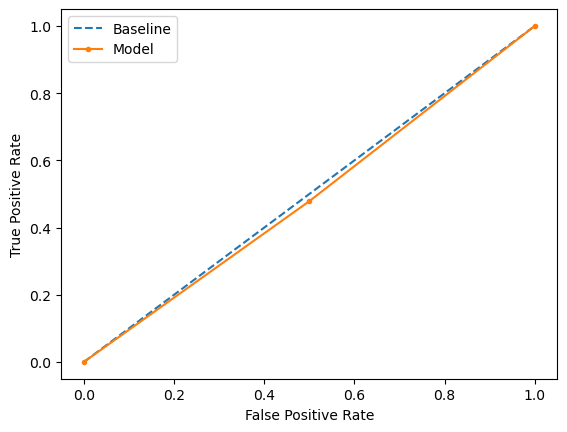

In [11]:
ROC_AUC_Graph(dumb_clf)

In [12]:
print(classification_report(y_test, y_te_pred))

              precision    recall  f1-score   support

           0       0.38      0.50      0.43        90
           1       0.60      0.48      0.53       140

    accuracy                           0.49       230
   macro avg       0.49      0.49      0.48       230
weighted avg       0.51      0.49      0.49       230



<AxesSubplot:>

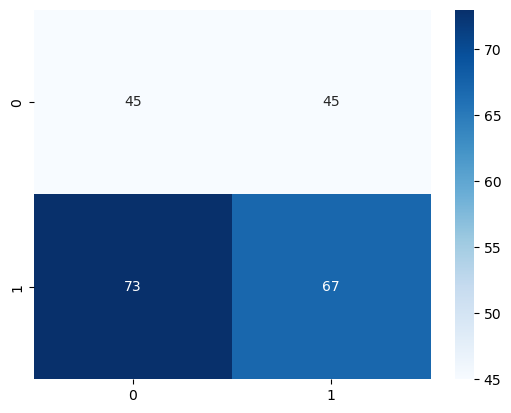

In [13]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_te_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

## Logistic Regression Model<a id='Logistic_Regression_Model'></a>

In [14]:
#Logistic Regression Pipeline
lg_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
    LogisticRegression(random_state=42)
)

In [15]:
#Cross-validate the default logistic regression model
lg_default_cv_results = cross_validate(lg_pipe, X_train, y_train, cv=5, scoring='roc_auc')
lg_cv_scores = lg_default_cv_results['test_score']

#Calculate and print the mean ROC AUC and standard deviation
mean_score = np.mean(lg_cv_scores)
std_score = np.std(lg_cv_scores)

print(f"Mean ROC AUC: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")

Mean ROC AUC: 0.9243
Standard Deviation: 0.0252


### Grid Search

In [16]:
#Define the parameter grid using a list of dictionaries
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear']
    }
]

#Create the GridSearchCV object
lg_grid_cv = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,  
    scoring='roc_auc'
)

In [17]:
lg_grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             scoring='roc_auc')

In [18]:
lg_grid_cv.best_params_

{'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}

### Scoring Model

In [19]:
lg_best_model = lg_grid_cv.best_estimator_

In [20]:
#Define a function to calculate and print cross-validation results
def print_cv_scores(model, X, y, dataset_name):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    print(f'{dataset_name} Cross-Validation Scores:')
    print(f'Mean ROC AUC: {mean_score:.4f}')
    print(f'Standard Deviation: {std_score:.4f}')


In [21]:
#Calculate and print cross-validation results for the training set
print_cv_scores(lg_best_model, X_train, y_train, 'Training')

#Calculate and print cross-validation results for the test set
print_cv_scores(lg_best_model, X_test, y_test, 'Test')

Training Cross-Validation Scores:
Mean ROC AUC: 0.9248
Standard Deviation: 0.0243
Test Cross-Validation Scores:
Mean ROC AUC: 0.9171
Standard Deviation: 0.0274


Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.867


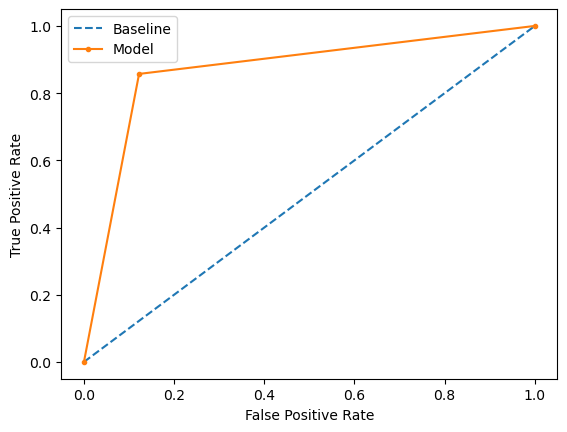

In [22]:
ROC_AUC_Graph(lg_best_model)

In [23]:
y_lg_pred = lg_best_model.predict(X_test)

In [24]:
#Classification Report
report = classification_report(y_test, y_lg_pred, output_dict = True)
lg_precision = report['weighted avg']['precision']
lg_recall = report['weighted avg']['recall']
lg_accuracy = report['accuracy']
print(classification_report(y_test, y_lg_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        90
           1       0.92      0.86      0.89       140

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



<AxesSubplot:>

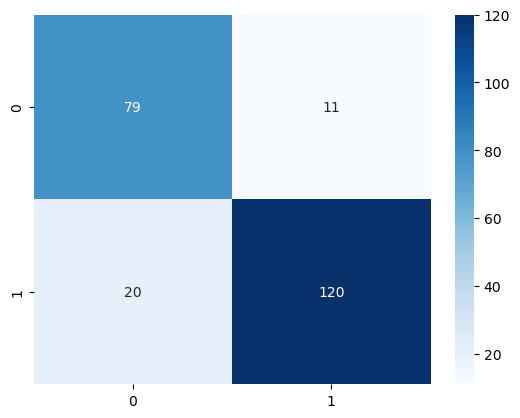

In [25]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_lg_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

## Random Forest Model<a id='Random_Forest_Model'></a>

In [26]:
rf_pipe = make_pipeline(
    RandomForestClassifier(random_state=42)
)

In [27]:
#Cross-validate the default logistic regression model
rf_default_cv_results = cross_validate(rf_pipe, X_train, y_train, cv=5, scoring='roc_auc')
rf_cv_scores = rf_default_cv_results['test_score']

#Calculate and print the mean ROC AUC and standard deviation
mean_score = np.mean(rf_cv_scores)
std_score = np.std(rf_cv_scores)

print(f"Mean ROC AUC: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")

Mean ROC AUC: 0.9146
Standard Deviation: 0.0233


### Random Search

In [28]:
rf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomforestclassifier', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [29]:
#Hyperparameter ranges
n_est = [int(n) for n in np.linspace(start=100, stop=1000, num=10)]
max_depth = [None] + list(range(10, 110, 10))

params = {
    'randomforestclassifier__n_estimators': n_est,
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': max_depth,
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', None],
    'randomforestclassifier__min_samples_split': [2, 5, 10, 20],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample', None],
}

#RandomizedSearchCV object
rf_random_cv = RandomizedSearchCV(
    estimator=rf_pipe, 
    param_distributions=params,
    cv=5,  
    n_jobs=-1,  
    scoring='roc_auc',
    random_state=42
)

In [30]:
rf_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__class_weight': ['balanced',
                                                                                 'balanced_subsample',
                                                                                 None],
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'randomforestclassifier__max_depth': [None,
                                                                     

In [31]:
rf_random_cv.best_params_

{'randomforestclassifier__n_estimators': 600,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__bootstrap': True}

### Scoring Model

In [32]:
rf_best_model = rf_random_cv.best_estimator_

In [33]:
#Calculate and print cross-validation results for the training set
print_cv_scores(rf_best_model, X_train, y_train, 'Training')

#Calculate and print cross-validation results for the test set
print_cv_scores(rf_best_model, X_test, y_test, 'Test')

Training Cross-Validation Scores:
Mean ROC AUC: 0.9212
Standard Deviation: 0.0212
Test Cross-Validation Scores:
Mean ROC AUC: 0.9131
Standard Deviation: 0.0202


Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.860


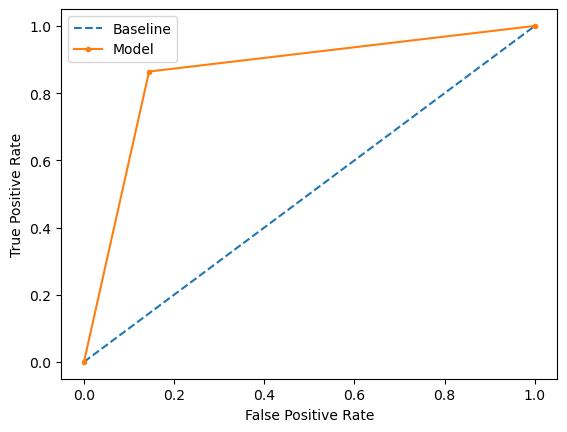

In [34]:
ROC_AUC_Graph(rf_best_model)

In [35]:
y_rf_pred = rf_best_model.predict(X_test)

In [36]:
#Classification Report
report = classification_report(y_test, y_rf_pred, output_dict = True)
rf_precision = report['weighted avg']['precision']
rf_recall = report['weighted avg']['recall']
rf_accuracy = report['accuracy']
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        90
           1       0.90      0.86      0.88       140

    accuracy                           0.86       230
   macro avg       0.85      0.86      0.86       230
weighted avg       0.86      0.86      0.86       230



<AxesSubplot:>

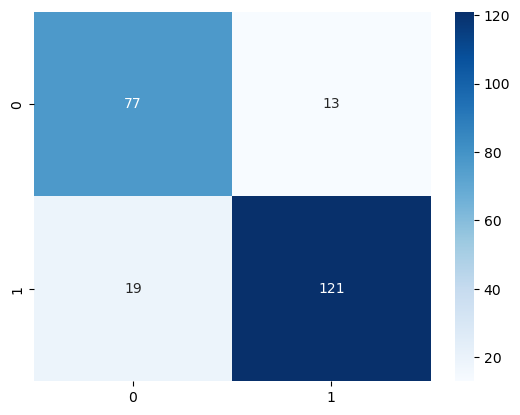

In [37]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_rf_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

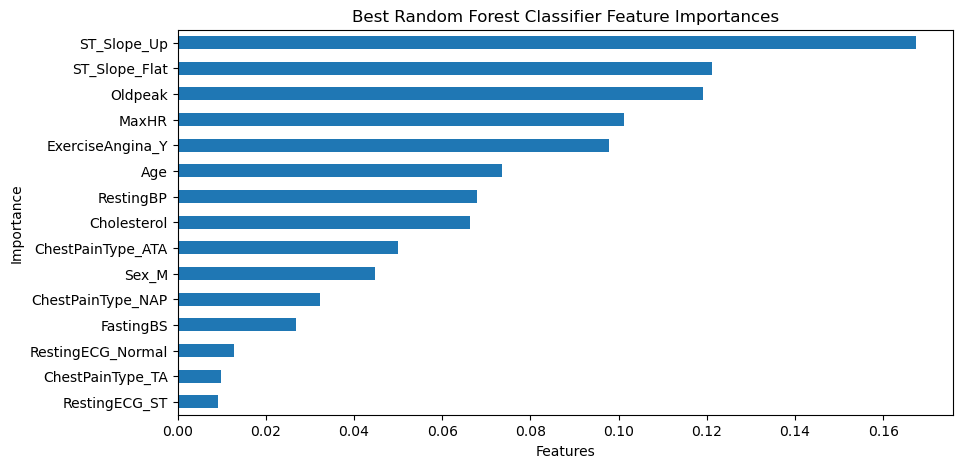

In [38]:
plt.subplots(figsize=(10, 5))
imps = rf_random_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(data = imps, index=X_train.columns).sort_values(ascending=True)
rf_feat_imps.plot(kind='barh')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best Random Forest Classifier Feature Importances');

## K-Nearest Neighbor (KNN) Model

In [39]:
#KNN Pipeline
knn_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
    KNeighborsClassifier()
)

In [40]:
# Cross-validate the KNN model
knn_cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=5, scoring='roc_auc')

# Calculate the mean and standard deviation of ROC AUC scores
mean_score = np.mean(knn_cv_scores)
std_score = np.std(knn_cv_scores)

print("KNN Cross-Validation Scores:")
print(f"Mean ROC AUC: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")

KNN Cross-Validation Scores:
Mean ROC AUC: 0.8866
Standard Deviation: 0.0297


### Grid Search

In [41]:
knn_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'minmaxscaler', 'kneighborsclassifier', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [42]:
#Parameter values
n_est = [int(x) for x in np.linspace(start=1, stop=100, num=50)]

#Parameter grid using a dictionary
params = {
    'kneighborsclassifier__n_neighbors': n_est,
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

#GridSearchCV object
knn_grid_cv = GridSearchCV(
    estimator=knn_pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc'
)

In [43]:
knn_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan',
                                                          'chebyshev',
                                                          'minkowski'],
                         'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11, 13, 15, 17,
                                                               19, 21, 23, 25,
                                                               27, 29, 31, 33,
                     

In [44]:
knn_grid_cv.best_params_

{'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 65,
 'kneighborsclassifier__weights': 'distance'}

### Scoring Model

In [45]:
knn_best_model = knn_grid_cv.best_estimator_

In [46]:
#Calculate and print cross-validation results for the training set
print_cv_scores(knn_best_model, X_train, y_train, 'Training')

#Calculate and print cross-validation results for the test set
print_cv_scores(knn_best_model, X_test, y_test, 'Test')

Training Cross-Validation Scores:
Mean ROC AUC: 0.9242
Standard Deviation: 0.0215
Test Cross-Validation Scores:
Mean ROC AUC: 0.9179
Standard Deviation: 0.0154


Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.851


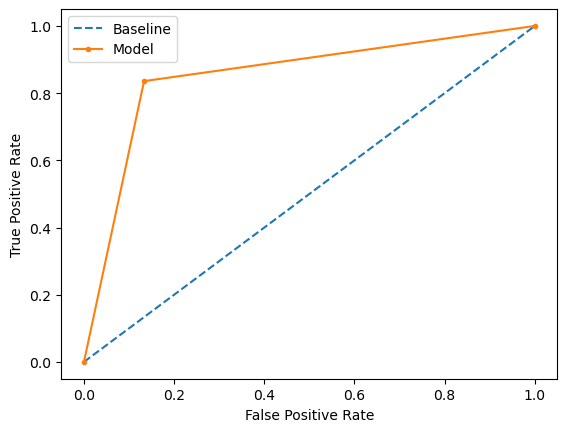

In [47]:
ROC_AUC_Graph(knn_best_model)

In [48]:
#Classification Report
y_knn_pred = knn_best_model.predict(X_test)
report = classification_report(y_test, y_knn_pred, output_dict = True)
knn_precision = report['weighted avg']['precision']
knn_recall = report['weighted avg']['recall']
knn_accuracy = report['accuracy']
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        90
           1       0.91      0.84      0.87       140

    accuracy                           0.85       230
   macro avg       0.84      0.85      0.84       230
weighted avg       0.85      0.85      0.85       230



<AxesSubplot:>

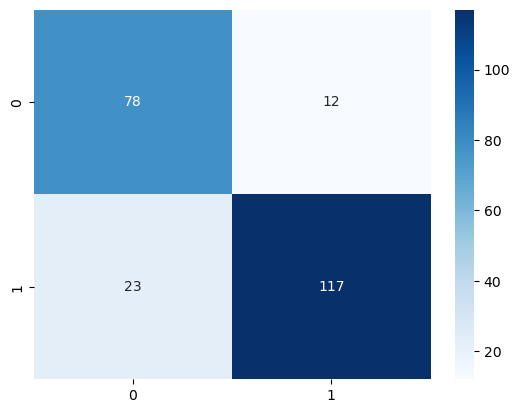

In [49]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_knn_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

## Gradient Boosting

In [50]:
#Gradient Boosting Pipeline
gb_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
    GradientBoostingClassifier(random_state=42)
)

In [51]:
# Cross-validate the default model
gb_default_cv_results = cross_validate(gb_pipe, X_train, y_train, cv=5, scoring='roc_auc')
gb_cv_scores = gb_default_cv_results['test_score']

In [52]:
mean_score = np.mean(gb_cv_scores)
std_score = np.std(gb_cv_scores)
print(f"Mean ROC AUC: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")

Mean ROC AUC: 0.9137
Standard Deviation: 0.0238


### Random Search

In [53]:
gb_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'minmaxscaler', 'gradientboostingclassifier', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'gradientboostingclassifier__ccp_alpha', 'gradientboostingclassifier__criterion', 'gradientboostingclassifier__init', 'gradientboostingclassifier__learning_rate', 'gradientboostingclassifier__loss', 'gradientboostingclassifier__max_depth', 'gradientboostingclassifier__max_features', 'gradientboostingclassifier__max_leaf_nodes', 'gradientboostingclassifier__min_impurity_decrease', 'gradientboostingclassifier__min_samples_leaf', 'gradientboostingclassifier__min_samples_split', 'gradientboostingclassifier__min_weight_fraction_leaf', 'gradientboostingclassifier__n_estimators', 'gradientboostingclassifier__n_iter_no_change', 'gradientboostingclassi

In [54]:
#Hyperparameter search space
n_est = np.linspace(start=1, stop=500, num=100, dtype=int)
max_depth = [5, 10, 15, 20, 25] 
learning_rate = [0.001, 0.01, 0.1, 0.2] 
min_samples_split = [2, 5, 10, 20]

params = {
    'gradientboostingclassifier__n_estimators': n_est,
    'gradientboostingclassifier__criterion': ['friedman_mse', 'squared_error'],
    'gradientboostingclassifier__max_depth': max_depth,
    'gradientboostingclassifier__learning_rate': learning_rate,
    'gradientboostingclassifier__min_samples_split': min_samples_split,
    'gradientboostingclassifier__warm_start': [True, False]
}

#RandomizedSearchCV object
gb_random_cv = RandomizedSearchCV(
    estimator=gb_pipe,
    param_distributions=params,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    random_state=42
)

In [55]:
gb_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('minmaxscaler', MinMaxScaler()),
                                             ('gradientboostingclassifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                                  'squared_error'],
                                        'gradientboostingclassifier__learnin...
       132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192,
       197, 202, 207, 212, 217, 222, 227, 232, 237, 242, 247, 253, 258,
       263, 268, 273, 278, 283, 288, 293, 298, 303, 308, 313, 318, 323,
       328, 333, 338, 343, 348, 353, 358, 363, 368, 373, 3

In [56]:
best_params = gb_random_cv.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'gradientboostingclassifier__warm_start': True, 'gradientboostingclassifier__n_estimators': 414, 'gradientboostingclassifier__min_samples_split': 20, 'gradientboostingclassifier__max_depth': 25, 'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__criterion': 'friedman_mse'}


### Scoring Model

In [57]:
gb_best_model = gb_random_cv.best_estimator_

In [58]:
#Calculate and print cross-validation results for the training set
print_cv_scores(gb_best_model, X_train, y_train, 'Training')

#Calculate and print cross-validation results for the test set
print_cv_scores(gb_best_model, X_test, y_test, 'Test')

Training Cross-Validation Scores:
Mean ROC AUC: 0.9083
Standard Deviation: 0.0286
Test Cross-Validation Scores:
Mean ROC AUC: 0.9127
Standard Deviation: 0.0173


Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.844


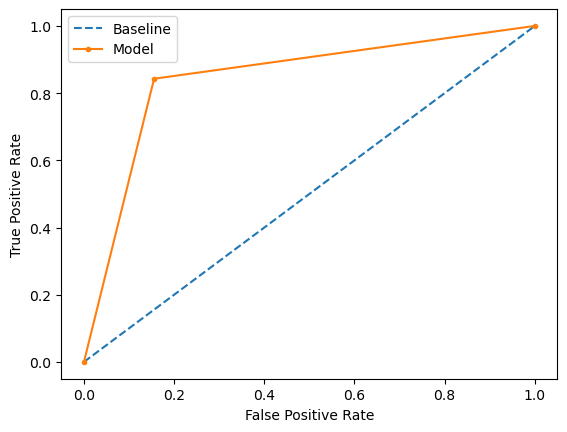

In [59]:
ROC_AUC_Graph(gb_best_model)

In [60]:
#Classification Report
y_gb_pred = gb_best_model.predict(X_test)
report = classification_report(y_test, y_gb_pred, output_dict = True)
gb_precision = report['weighted avg']['precision']
gb_recall = report['weighted avg']['recall']
gb_accuracy = report['accuracy']
print(classification_report(y_test, y_gb_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        90
           1       0.89      0.84      0.87       140

    accuracy                           0.84       230
   macro avg       0.83      0.84      0.84       230
weighted avg       0.85      0.84      0.84       230



<AxesSubplot:>

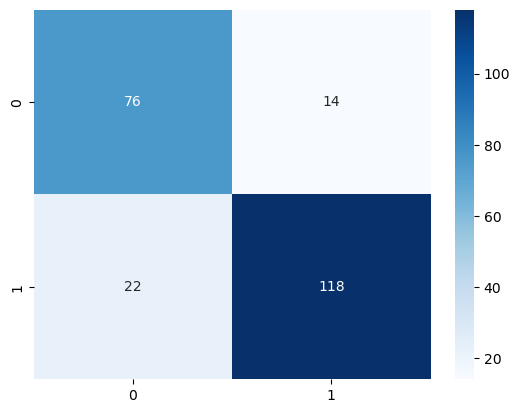

In [61]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_gb_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

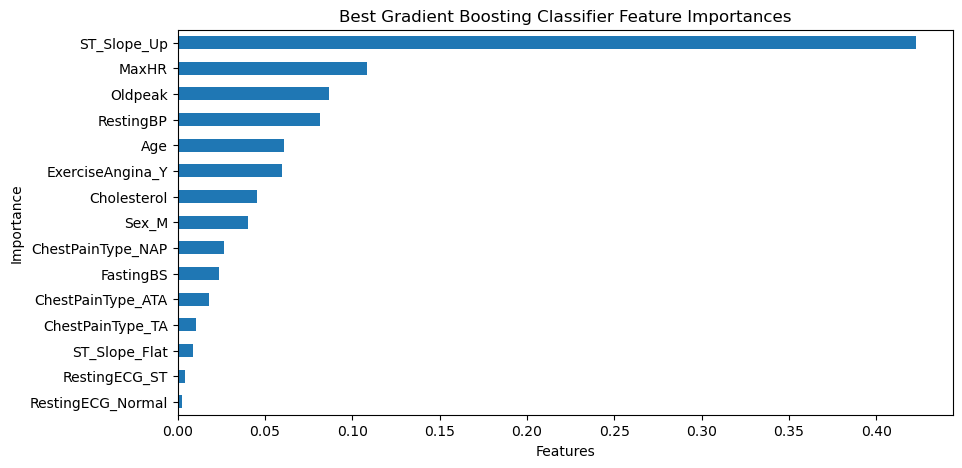

In [62]:
plt.subplots(figsize=(10, 5))
imps = gb_random_cv.best_estimator_.named_steps.gradientboostingclassifier.feature_importances_
rf_feat_imps = pd.Series(data = imps, index=X_train.columns).sort_values(ascending=True)
rf_feat_imps.plot(kind='barh')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best Gradient Boosting Classifier Feature Importances');

## Comparison of the models

In [63]:
#Define the function to calculate cross-validation scores
def calculate_cv_scores(model, X, y, scoring='roc_auc'):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    return mean_score, std_score

#Data
myLabels = ['Logistic Regression', 'Random Forest', 'KNN', 'Gradient Boost']
score_train = []
score_test = []
precision = []
recall = []
accuracy = []

#Iterate over each algorithm and calculate the scores
for label in myLabels:
    if label == 'Logistic Regression':
        model = lg_best_model
    elif label == 'Random Forest':
        model = rf_best_model
    elif label == 'KNN':
        model = knn_best_model
    elif label == 'Gradient Boost':
        model = gb_best_model
    
    #Calculate CV scores for train set
    mean_score_train, std_score_train = calculate_cv_scores(model, X_train, y_train, scoring='roc_auc')
    score_train.append(mean_score_train)
    
    #Calculate CV scores for test set
    mean_score_test, std_score_test = calculate_cv_scores(model, X_test, y_test, scoring='roc_auc')
    score_test.append(mean_score_test)
    
    #Calculate other scores for test set
    mean_precision, std_precision = calculate_cv_scores(model, X_test, y_test, scoring='precision')
    precision.append(mean_precision)
    
    mean_recall, std_recall = calculate_cv_scores(model, X_test, y_test, scoring='recall')
    recall.append(mean_recall)
    
    mean_accuracy, std_accuracy = calculate_cv_scores(model, X_test, y_test, scoring='accuracy')
    accuracy.append(mean_accuracy)
    
#DataFrame
score_tab = pd.DataFrame({
    'Algorithm': myLabels,
    'ROC-AUC Train Score': score_train,
    'ROC-AUC Test Score': score_test,
    'Precision': precision,
    'Recall': recall,
    'Accuracy': accuracy,
})

score_tab.head()



,Algorithm,ROC-AUC Train Score,ROC-AUC Test Score,Precision,Recall,Accuracy
0,Logistic Regression,0.924819,0.917063,0.883016,0.914286,0.873913
1,Random Forest,0.921195,0.913095,0.882638,0.900000,0.865217
2,KNN,0.924243,0.917857,0.868354,0.892857,0.852174
3,Gradient Boost,0.908318,0.912698,0.864228,0.907143,0.856522


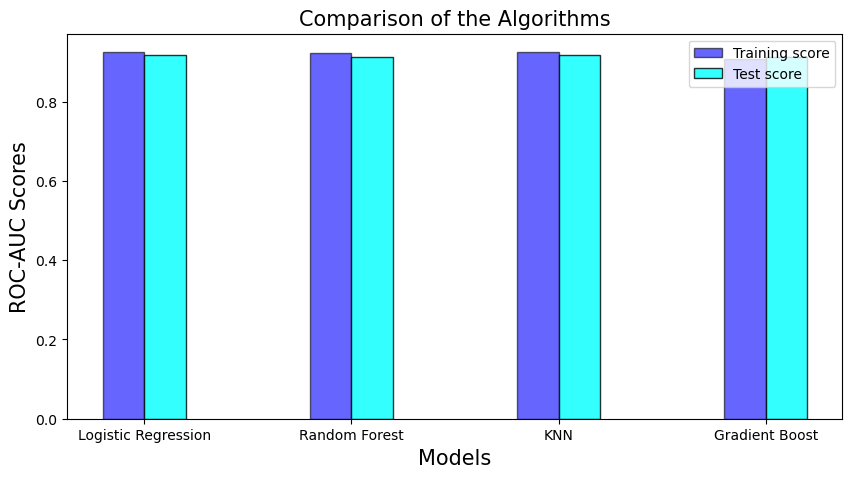

In [64]:
#Plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4]
index_acc=[1.2,2.2,3.2,4.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC Scores',fontsize=15)
plt.title('Comparison of the Algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1.1, 2.1,3.1,4.1], myLabels)
plt.legend()
plt.show()

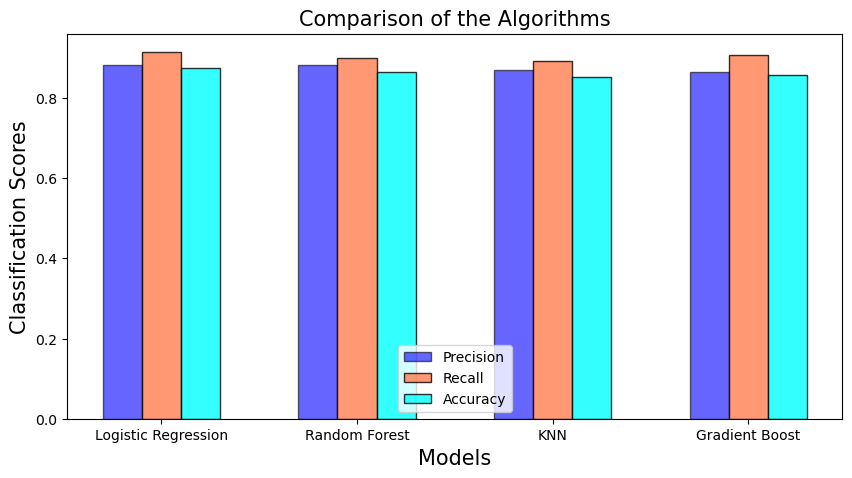

In [65]:
#Plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4]
index_abb=[1.2,2.2,3.2,4.2]
index_acc=[1.4,2.4,3.4,4.4]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Classification Scores',fontsize=15)
plt.title('Comparison of the Algorithms',fontsize=15)
_=plt.bar(index,precision,color='b',alpha=0.6,label='Precision',edgecolor='k',width=0.2)
_=plt.bar(index_abb,recall,color='coral',alpha=0.8,label='Recall',edgecolor='k',width=0.2)
_=plt.bar(index_acc,accuracy,color='cyan',alpha=0.8,label='Accuracy',edgecolor='k',width=0.2)
plt.xticks([1.2, 2.2, 3.2, 4.2], myLabels)
plt.legend()
plt.show()

##  Conclusion

To initiate the modeling process for the provided dataset, it was imperative to promptly establish a baseline model. This baseline model would serve as a reference point for evaluating the performance of subsequent models. To accomplish this, I implemented a random classifier that employed a uniform prediction method, akin to flipping a coin, to make predictions on the test data. This approach allowed for random predictions with equal probability for each class, creating a fundamental starting point.

I evaluated the performance of this random classifier using key metrics such as ROC AUC, a classification report, and a confusion matrix. These evaluations provided essential baseline data that served as a foundation for implementing and assessing four selected models, which showed promise in achieving the desired outcome. The chosen models were Logistic Regression, K-Nearest Neighbors (KNN), Random Forest, and Gradient Boosting.

For each of these models, I followed a consistent procedure. Firstly, I constructed individual pipelines using the aforementioned models. Then, depending on the model's characteristics and fitting time, I employed either grid search or random search cross-validation to fine-tune the hyperparameters. Finally, I assessed each model using the scoring methods mentioned above.

After comparing the updated scores, it is evident that the Logistic Regression model stands out as the optimal choice among the four models considered. It demonstrates the highest ROC-AUC, Precision, Recall, and Accuracy scores. Given the critical nature of the medical context in which false negatives should be minimized, the high recall score of 0.914 suggests that this model excels in correctly identifying relevant cases.

However, it's worth noting that the Random Forest model also performed admirably, closely trailing the Logistic Regression model in most scoring metrics, with a respectable ROC-AUC Test Score of 0.913 and a Recall score of 0.900. While it falls slightly short in terms of precision and accuracy compared to Logistic Regression, Random Forest's performance is still commendable, and it may offer a compelling alternative depending on specific priorities and constraints.


In [66]:
best_model = rf_random_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [67]:
# saveing model

modelpath = '../models'
save_file(best_model, 'heart_disease_model.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models/heart_disease_model.pkl"
